# 데이터 불러오기

In [1]:
import yfinance as yf
TSLA = yf.download("TSLA", start="2019-01-01", end="2023-03-31")
TSLA.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-01-02,20.406668,21.008667,19.920000,20.674667,20.674667,174879000
2019-01-03,20.466667,20.626667,19.825333,20.024000,20.024000,104478000
2019-01-04,20.400000,21.200001,20.181999,21.179333,21.179333,110911500
2019-01-07,21.448000,22.449333,21.183332,22.330667,22.330667,113268000
2019-01-08,22.797333,22.934000,21.801332,22.356667,22.356667,105127500


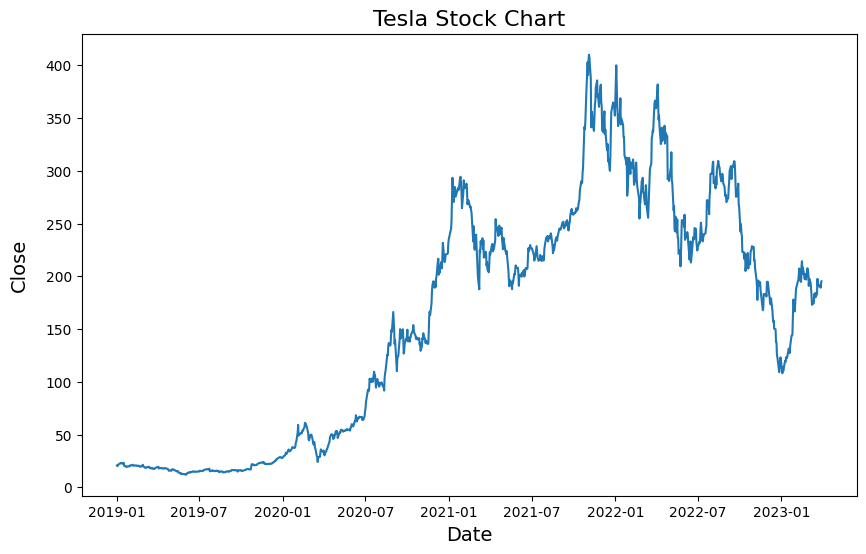

In [2]:
import seaborn as sns 
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
formatter = ScalarFormatter()
formatter.set_scientific(False)

fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(data=TSLA, x=TSLA.index, y=TSLA.Close, ax=ax)
ax.set_title('Tesla Stock Chart', size = 16)
ax.set_xlabel('Date', size = 14)
ax.set_ylabel('Close', size = 14, labelpad=12)
ax.yaxis.set_major_formatter(formatter)

plt.savefig('output/scikit-learn01.png', dpi=200)
plt.show()

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import warnings
warnings.filterwarnings("ignore")

def tsplot(y, lags=None, figsize=(10, 6), tickerName = "stock", outputname = 'output/scikit-learn.png'):
    """시계열 그래프, ACF, PACF, Dickey–Fuller test 계산한다. 
    Parameters:
        y : 시계열 데이터
        lags : ACF, PACF, Dickey-Fuller 검정
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    
    p_value = np.round(sm.tsa.stattools.adfuller(y)[1], 2)

    fig = plt.figure(figsize=figsize)
    layout = (0.5, 0.5)

    spec = fig.add_gridspec(nrows=2, ncols=2, height_ratios=layout, width_ratios=layout)

    ### 2. setting axes
    axs = {}
    for i in range(len(layout)*len(layout)):
        if i >= 2:
            axs[i] = fig.add_subplot(spec[i//len(layout), i%len(layout)])
            # axs[i].text(0.5, 0.5, f"axs[{i}]", fontdict={"horizontalalignment":"center", "color":"gray"})
        else:
            axs[i] = fig.add_subplot(spec[i//len(layout), :])
            # axs[i].text(0.5, 0.5, f"axs[{i}]", fontdict={"horizontalalignment":"center", "color":"gray"})

    fig.delaxes(axs[0])

    axs[1].plot(y)
    axs[1].set_title(f'{tickerName} Stock Time Series Analysis Plots\n Dickey-Fuller: p={p_value}')

    smt.graphics.plot_acf(y, lags=lags, ax=axs[2])
    axs[2].set_ylim(-1.5, 1.5)
    axs[2].set_title('Autocorrelation')
    smt.graphics.plot_pacf(y, lags=lags, ax=axs[3])
    
    axs[3].set_ylim(-1.5, 1.5)
    axs[3].set_title('Partial Autocorrelation')

    fig.tight_layout()
    plt.savefig(outputname, dpi=200)
    plt.show()

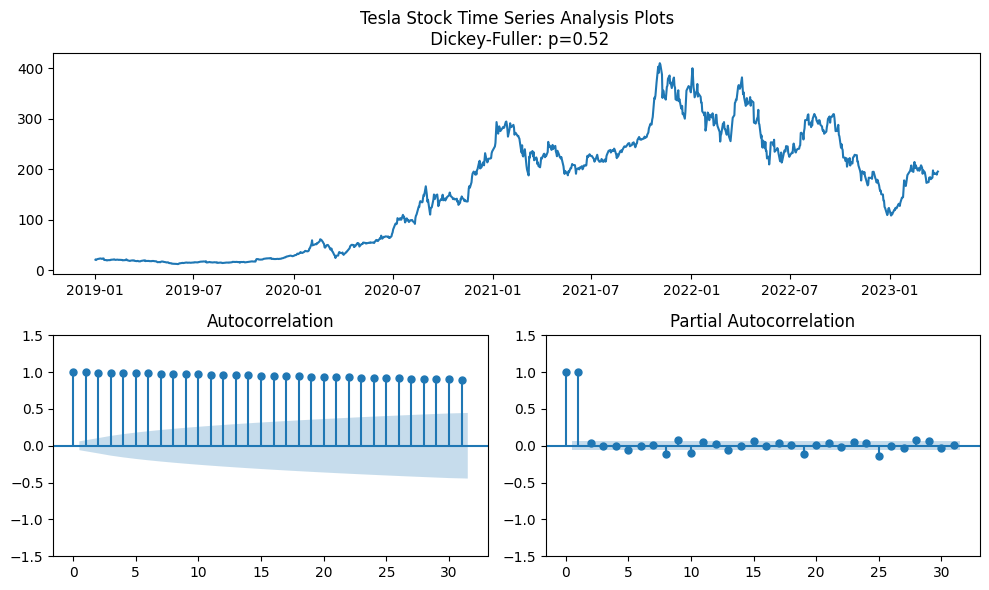

In [4]:
tsplot(TSLA.Close, tickerName = "Tesla", outputname = 'output/scikit-learn02.png')

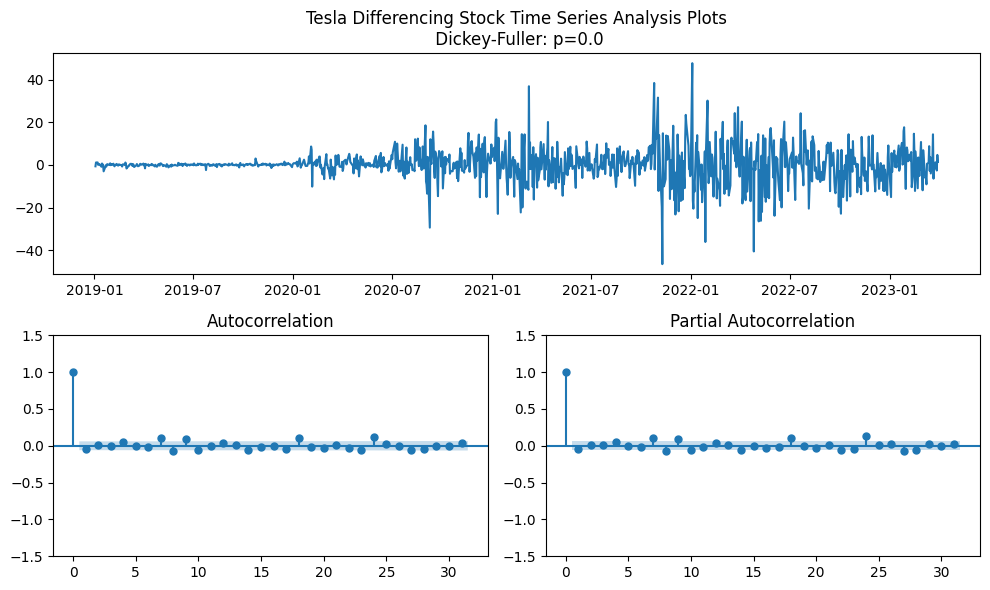

In [5]:
ts_sun_diff = (TSLA.Close - TSLA.Close.shift(1)).dropna()
tsplot(ts_sun_diff, tickerName = "Tesla Differencing", outputname = 'output/scikit-learn03.png')

In [6]:
test_len = int(len(TSLA.Close) * 0.2)
TSLA_train, TSLA_test = TSLA.Close.iloc[:-test_len], TSLA.Close.iloc[-test_len:]
TSLA_train.shape, TSLA_test.shape

((856,), (213,))

In [7]:
TSLA_train[:5]

Date
2019-01-02    20.674667
2019-01-03    20.024000
2019-01-04    21.179333
2019-01-07    22.330667
2019-01-08    22.356667
Name: Close, dtype: float64

In [8]:
TSLA_test[:5]

Date
2022-05-25    219.600006
2022-05-26    235.910004
2022-05-27    253.210007
2022-05-31    252.753326
2022-06-01    246.789993
Name: Close, dtype: float64

In [9]:
from sktime.forecasting.arima import AutoARIMA

train_dates = TSLA_train.index
forecaster = AutoARIMA(start_p=8, max_p=9, suppress_warnings=True)
TSLA_train.index = TSLA_train.index.astype(int)
forecaster.fit(TSLA_train)
forecaster.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  856
Model:               SARIMAX(9, 1, 2)   Log Likelihood               -2921.474
Date:                Thu, 20 Apr 2023   AIC                           5866.948
Time:                        21:02:03   BIC                           5923.961
Sample:                             0   HQIC                          5888.781
                                - 856                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0291      0.045    -22.827      0.000      -1.117      -0.941
ar.L2         -0.8970      0.047    -19.160      0.000      -0.989      -0.805
ar.L3         -0.0072      0.041     -0.175      0.861      -0.087       0.073
ar.L4          0.0549      0.040      1.361      0.173      -0.024       0.134
ar.L5          0.0499      0.041      1.216      0.224      -0.031       0.130
ar.L6          0.0058      0.039      0.150      0.881      -0.070       0.082
ar.L7          0.1026      0.033      3.147      0.002       0.039       0.167
ar.L8          0.0382      0.029      1.335      0.182      -0.018       0.094
ar.L9          0.1210      0.028      4.396      0.000       0.067       0.175
ma.L1          1.0204      0.036     28.464      0.000       0.950       1.091
ma.L2          0.8981      0.034     26.791      0.000       0.832       0.964
sigma2        54.3502      1.351     40.240      0.000      51.703      56.997
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              1817.97
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):              79.89   Skew:                            -0.11
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.14
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

fh = np.arange(test_len) + 1
forecast = forecaster.predict(fh=fh)
coverage = 0.95
forecast_int = forecaster.predict_interval(fh=fh, coverage=coverage)['Coverage'][coverage]

TSLA_train.index = train_dates
forecast.index = TSLA_test.index

mae = np.round(mean_absolute_error(TSLA_test, forecast), 2)
mape = np.round(mean_absolute_percentage_error(TSLA_test, forecast), 2)

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(TSLA_train.index, TSLA_train.values, label="train", color = 'b')
ax.plot(TSLA_test.index, TSLA_test.values, label="test", color = 'g')
ax.plot(forecast.index, forecast.values, label="forecast", color = 'r')
ax.fill_between(TSLA_test.index, 
                forecast_int["lower"],
                forecast_int["upper"],
                alpha=0.2, 
                color="dimgray")

ax.set_title(f'MAE: {mae}, MAPE: {mape}')
plt.legend(prop={'size':16})
plt.savefig("output/scikit-learn04.png", dpi=200)
plt.show()

## LightGBM

In [11]:
import numpy as np
import pandas as pd

import lightgbm as lgb
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller

from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.compose import (TransformedTargetForecaster,
                                        make_reduction)
from sktime.forecasting.model_selection import (ExpandingWindowSplitter,
                                                ForecastingGridSearchCV)
from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError
from sktime.transformations.series.detrend import Deseasonalizer, Detrender
from sktime.utils.plotting import plot_series

import warnings
warnings.filterwarnings("ignore")

In [10]:
import statsmodels.api as sm
import pandas as pd 

timeseries_df = sm.datasets.get_rdataset("Nile").data
timeseries_df = timeseries_df.set_index('time').value
timeseries_df

time
1871    1120
1872    1160
1873     963
1874    1210
1875    1160
        ... 
1966     746
1967     919
1968     718
1969     714
1970     740
Name: value, Length: 100, dtype: int64

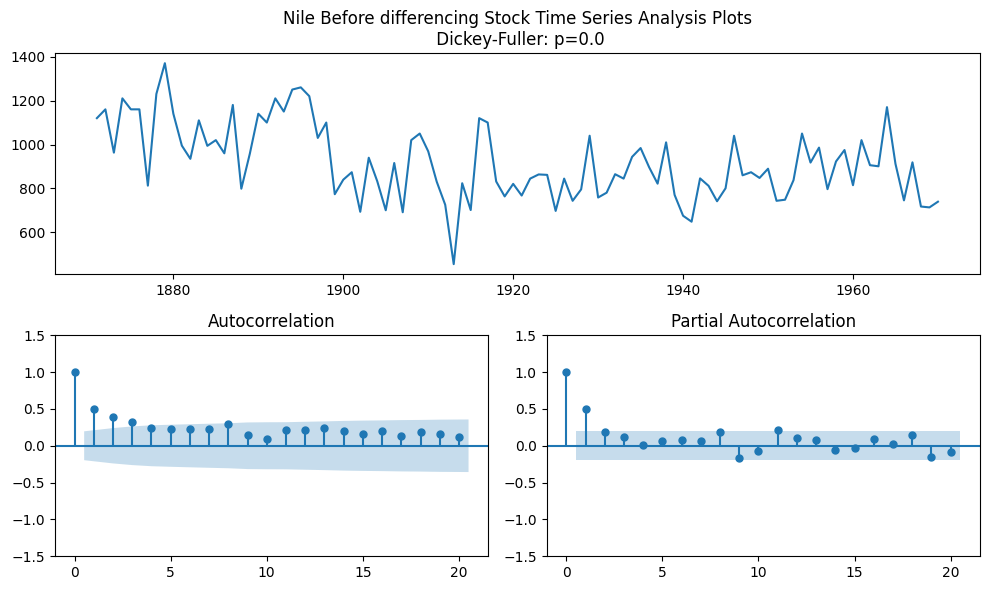

In [12]:
tsplot(timeseries_df, tickerName = "Nile Before differencing", outputname = 'output/scikit-learn05.png')

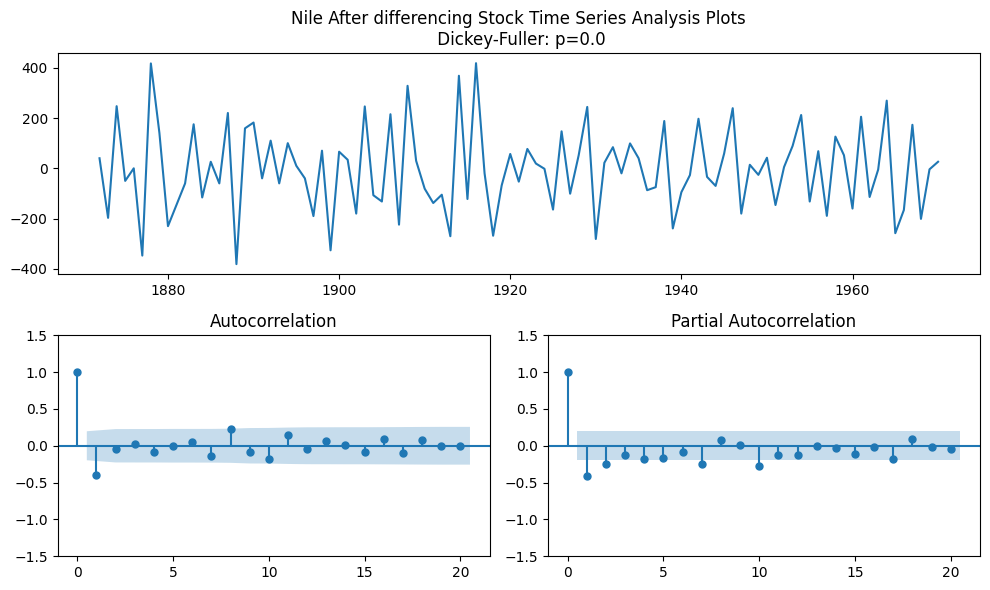

In [13]:
ts_nl_diff = (timeseries_df - timeseries_df.shift(1)).dropna()
tsplot(ts_nl_diff, tickerName = "Nile After differencing", outputname = 'output/scikit-learn06.png')

In [14]:
test_len = int(len(timeseries_df) * 0.3)
train, test = timeseries_df.iloc[:-test_len], timeseries_df.iloc[-test_len:]
train.shape, test.shape

((70,), (30,))

In [15]:
regressor = lgb.LGBMRegressor()
forecaster = make_reduction(regressor, window_length=5, strategy="recursive")
forecaster

RecursiveTabularRegressionForecaster(estimator=LGBMRegressor(), window_length=5)

In [16]:
param_grid = {"window_length": [6, 12]}
cv = ExpandingWindowSplitter(initial_window=int(len(train) * 0.7))
gscv = ForecastingGridSearchCV(
        forecaster, strategy="refit", cv=cv, param_grid=param_grid, 
        scoring=MeanAbsolutePercentageError(symmetric=True))
gscv.fit(train)
print(f"best params: {gscv.best_params_}")

best params: {'window_length': 6}


In [17]:
fh = np.arange(len(test)) + 1
y_pred = gscv.predict(fh=fh)
y_pred[:5]

1941    973.096051
1942    895.924521
1943    852.563049
1944    977.141101
1945    838.803281
Name: value, dtype: float64

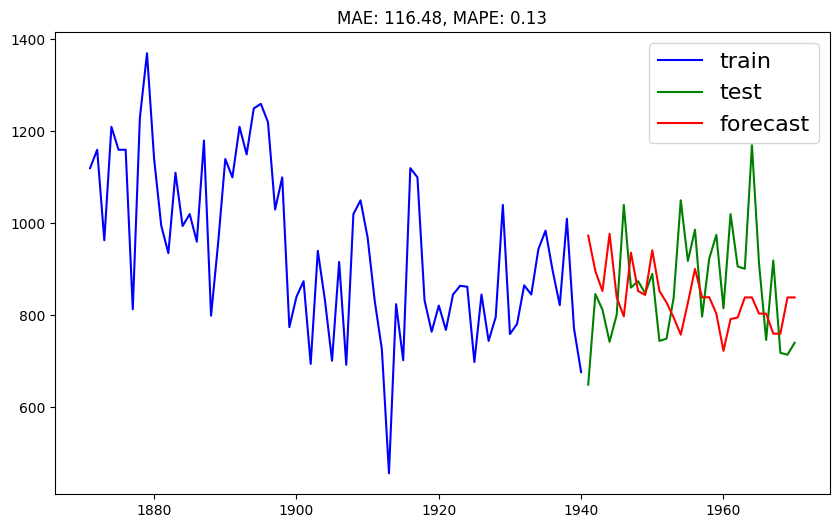

In [18]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

mae = np.round(mean_absolute_error(test, y_pred), 2)
mape = np.round(mean_absolute_percentage_error(test, y_pred), 2)

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(train.index, train.values, label="train", color = 'b')
ax.plot(test.index, test.values, label="test", color = 'g')
ax.plot(y_pred.index, y_pred.values, label="forecast", color = 'r')

ax.set_title(f'MAE: {mae}, MAPE: {mape}')
plt.legend(prop={'size':16})
plt.savefig("output/scikit-learn07.png", dpi=200)
plt.show()

## Prophet

In [27]:
from prophet import Prophet
from sktime.datasets import load_airline
airline_df = load_airline()
airline_df

# 수정할 것

Period
1949-01    112.0
1949-02    118.0
1949-03    132.0
1949-04    129.0
1949-05    121.0
           ...  
1960-08    606.0
1960-09    508.0
1960-10    461.0
1960-11    390.0
1960-12    432.0
Freq: M, Name: Number of airline passengers, Length: 144, dtype: float64

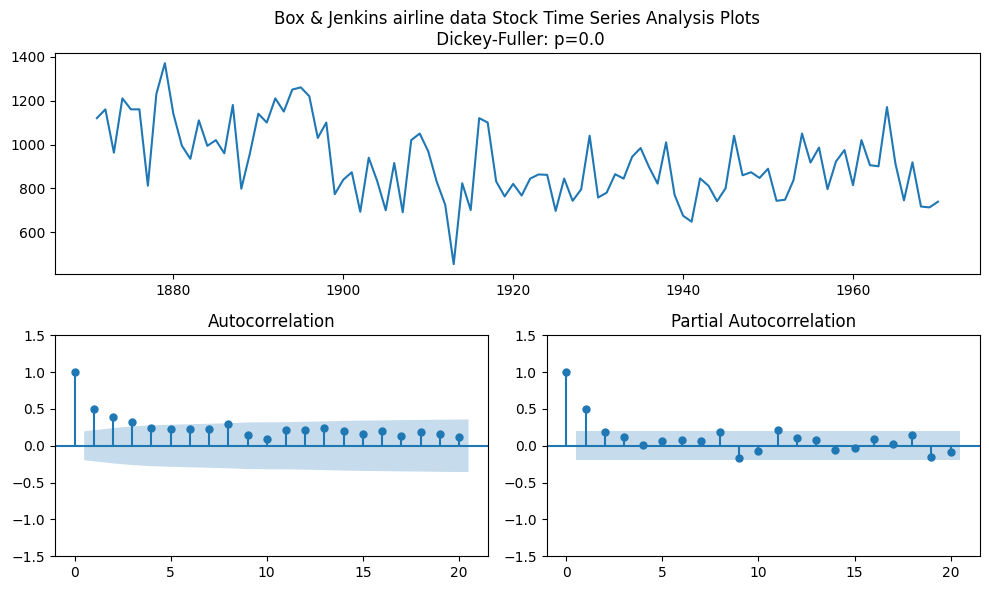

In [20]:
tsplot(airline_df, tickerName = "Box & Jenkins airline data", outputname = 'output/scikit-learn08.png')

In [22]:
test_len = int(len(airline_df) * 0.3)
train, test = airline_df.iloc[:-test_len], airline_df.iloc[-test_len:]
train.shape, test.shape

((70,), (30,))

In [25]:
# train_pp = train.to_timestamp(freq="M").reset_index()
train_pp.columns = ["ds", "y"]
train_pp.head()

NameError: name 'train_pp' is not defined

In [ ]:
model = Prophet(
    seasonality_mode="multiplicative",
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
)
model.fit(train_pp)

future = model.make_future_dataframe(periods=test_len, freq="M")
forecast = model.predict(future)
forecast = forecast.iloc[-test_len:]
forecast = forecast.rename(columns={"yhat_lower": "lower", "yhat_upper": "upper"})
forecast.head()

In [ ]:
forecast.info()

In [ ]:
forecast.index = test.index

mae = np.round(mean_absolute_error(test, forecast['yhat']), 2)
mape = np.round(mean_absolute_percentage_error(test, forecast['yhat']), 2)

fig, ax = plt.subplots(figsize=(10, 6))
train.plot(label='train', color = 'b', ax=ax)
test.plot(label='test', color = 'g', ax=ax)

ax.plot(forecast["yhat"].index, forecast["yhat"].values, label="forecast", color = 'r')
ax.fill_between(test.index, 
                forecast["lower"],
                forecast["upper"],
                alpha=0.2, 
                color="dimgray")

ax.set_title(f'MAE: {mae}, MAPE: {mape}')
plt.legend(prop={'size':16})
plt.savefig("output/scikit-learn09.png", dpi=200)
plt.show()